In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#installing packages
#!pip install -r requirements.txt 

# Start Running Cells from Here

In [3]:
import numpy as np
import pandas as pd
import math
import random

from nltk.corpus import stopwords
import nltk

import sklearn
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import scipy
from scipy.sparse import vstack

In [4]:
article_df=pd.read_csv('/kaggle/input/articles-sharing-reading-from-cit-deskdrop/shared_articles.csv')
interactions_df=pd.read_csv('/kaggle/input/articles-sharing-reading-from-cit-deskdrop/users_interactions.csv')

In [5]:
article_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


## Going through the shared_articles dataset 

In [6]:
article_df.shape , interactions_df.shape 

((3122, 13), (72312, 8))

In [7]:
article_df.dtypes

timestamp           int64
eventType          object
contentId           int64
authorPersonId      int64
authorSessionId     int64
authorUserAgent    object
authorRegion       object
authorCountry      object
contentType        object
url                object
title              object
text               object
lang               object
dtype: object

In [8]:
for col in article_df.columns:
    if article_df[col].dtype == 'object':
        print(col,end='')
        if article_df[col].nunique() < 100:
            print(':',article_df[col].unique(),end='')
        
        print('\n')

eventType: ['CONTENT REMOVED' 'CONTENT SHARED']

authorUserAgent

authorRegion: [nan 'MG' 'ON' 'SP' 'GA' 'NY' 'IL' 'NSW' 'RI' 'NJ' 'RJ' 'TX' 'AB' 'FL'
 '13' 'WA' '?' 'CA' 'SC' 'MS']

authorCountry: [nan 'BR' 'CA' 'US' 'AU' 'PT']

contentType: ['HTML' 'RICH' 'VIDEO']

url

title

text

lang: ['en' 'pt' 'es' 'la' 'ja']



In [9]:
article_df.isna().sum()

timestamp             0
eventType             0
contentId             0
authorPersonId        0
authorSessionId       0
authorUserAgent    2442
authorRegion       2442
authorCountry      2442
contentType           0
url                   0
title                 0
text                  0
lang                  0
dtype: int64

### Cleaning the dataset

In [10]:
cleaned_article = article_df[article_df['eventType']=='CONTENT SHARED']

In [11]:
cleaned_article.shape, article_df.shape 

((3047, 13), (3122, 13))

## Going through the users_interactions dataset 

In [12]:
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [13]:
interactions_df.dtypes

timestamp       int64
eventType      object
contentId       int64
personId        int64
sessionId       int64
userAgent      object
userRegion     object
userCountry    object
dtype: object

In [14]:
for col in interactions_df.columns:
    if interactions_df[col].dtype == 'object':
        print(col,end='')
        if interactions_df[col].nunique() < 100:
            print(':',interactions_df[col].unique(),end='')
        
        print('\n')

eventType: ['VIEW' 'FOLLOW' 'BOOKMARK' 'LIKE' 'COMMENT CREATED']

userAgent

userRegion: [nan 'NY' 'MG' 'SP' 'RJ' 'GA' 'CA' '?' 'NJ' 'TX' '49' 'MH' 'D' 'PA' 'VA'
 'BE' 'AZ' 'IL' 'MI' 'FL' 'ES' 'BW' 'MA' 'PR' 'BC' 'NSW' 'DF' 'C' 'HE'
 'ON' 'MS' '13' '11' 'DC' 'NE' 'NC' '33' 'CO' 'LA' 'ENG' 'GO' '14' 'IN'
 'CT' '45' '27' 'WA' 'PE' 'MO' 'MN' 'RS' 'NH' '41' 'SC' 'BA' 'WI' 'RM'
 'OK' 'OH' 'CE' 'RI' 'AB' 'R' 'BOL' 'NV' 'OR' 'KS' 'ZH' 'MT' 'QLD' 'PI'
 'CL']

userCountry: [nan 'US' 'BR' 'JP' 'KR' 'IN' 'IE' 'SG' 'DE' 'CA' 'IS' 'AU' 'ZZ' 'ES' 'CN'
 'GB' 'MY' 'AR' 'NL' 'CL' 'IT' 'CO' 'PT' 'CH']



In [15]:
interactions_df.isna().sum()

timestamp          0
eventType          0
contentId          0
personId           0
sessionId          0
userAgent      15394
userRegion     15405
userCountry    15394
dtype: int64

In [16]:
#adding a new columns event_strength 
event_strength = {'VIEW': 1.0, 'FOLLOW':2.0, 'BOOKMARK':3.0,
                  'LIKE':4.0, 'COMMENT CREATED':5.0}
interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_strength[x])

In [17]:
interactions_df[['eventType','eventStrength']]

,eventType,eventStrength
0,VIEW,1.0
1,VIEW,1.0
2,VIEW,1.0
3,FOLLOW,2.0
4,VIEW,1.0
...,...,...
72307,LIKE,4.0
72308,VIEW,1.0
72309,VIEW,1.0
72310,VIEW,1.0


In [18]:

interactions_df.groupby(['personId', 'contentId']).size()

personId              contentId           
-9223121837663643404  -8949113594875411859    1
                      -8377626164558006982    1
                      -8208801367848627943    1
                      -8187220755213888616    1
                      -7423191370472335463    8
                                             ..
 9210530975708218054   8477804012624580461    4
                       8526042588044002101    1
                       8856169137131817223    1
                       8869347744613364434    1
                       9209886322932807692    1
Length: 40710, dtype: int64

In [19]:
users_count = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
users_count

personId
-9223121837663643404    43
-9212075797126931087     5
-9207251133131336884     7
-9199575329909162940    11
-9196668942822132778     7
                        ..
 9165571805999894845     5
 9187866633451383747    17
 9191849144618614467    12
 9199170757466086545    14
 9210530975708218054    63
Length: 1895, dtype: int64

In [20]:
active_users = users_count[users_count>=5].copy()
active_users

personId
-9223121837663643404    43
-9212075797126931087     5
-9207251133131336884     7
-9199575329909162940    11
-9196668942822132778     7
                        ..
 9165571805999894845     5
 9187866633451383747    17
 9191849144618614467    12
 9199170757466086545    14
 9210530975708218054    63
Length: 1140, dtype: int64

In [21]:
active_users_Id = active_users.reset_index()[['personId']]
active_users_Id

,personId
0,-9223121837663643404
1,-9212075797126931087
2,-9207251133131336884
3,-9199575329909162940
4,-9196668942822132778
...,...
1135,9165571805999894845
1136,9187866633451383747
1137,9191849144618614467
1138,9199170757466086545


In [22]:
interactions_active_users = interactions_df.merge(active_users_Id, how='right', 
                                                  left_on='personId', right_on='personId')

In [23]:
interactions_active_users

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1463138398,VIEW,7516228655554309785,-9223121837663643404,-4482197405545551645,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,SP,BR,1.0
1,1463656314,VIEW,3041906492387035176,-9223121837663643404,-7824685088995468735,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,SP,BR,1.0
2,1464113091,VIEW,-3750879736572068916,-9223121837663643404,-2774275024909061125,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,SP,BR,1.0
3,1462283851,VIEW,-730957269757756529,-9223121837663643404,2625340673871268120,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,SP,BR,1.0
4,1462452127,VIEW,-8949113594875411859,-9223121837663643404,-3673331845456357462,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,SP,BR,1.0
...,...,...,...,...,...,...,...,...,...
69863,1482932930,VIEW,-1572252285162838958,9210530975708218054,-7673376373070890422,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
69864,1484126240,VIEW,3660989387512978561,9210530975708218054,1216354488778990261,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
69865,1483015651,VIEW,-1572252285162838958,9210530975708218054,-2172456475209001768,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0
69866,1483015617,VIEW,-1572252285162838958,9210530975708218054,-2172456475209001768,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR,1.0


In [24]:
interactions_active_users.groupby(['eventType', 'eventStrength']).size()

eventType        eventStrength
BOOKMARK         3.0               2420
COMMENT CREATED  5.0               1579
FOLLOW           2.0               1379
LIKE             4.0               5625
VIEW             1.0              58865
dtype: int64

### Applying log transformation to smooth the distribution

In [25]:
def smooth_user_preference(x):
    return math.log(x+1, 2)

In [26]:
interactions_full = interactions_active_users.groupby(['personId', 'contentId'])['eventStrength'].sum().apply(smooth_user_preference).reset_index()
                                        

interactions_full

,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
...,...,...,...
39101,9210530975708218054,8477804012624580461,3.459432
39102,9210530975708218054,8526042588044002101,1.000000
39103,9210530975708218054,8856169137131817223,1.000000
39104,9210530975708218054,8869347744613364434,1.000000


# Items Profile

using TFIDF and cosine similarity for items feature engineering

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
stopwords_list = stopwords.words('english') + stopwords.words('portuguese') 

vectorizer = TfidfVectorizer(analyzer = 'word', 
                            ngram_range = (1,2),
                            min_df = 0.003,
                            max_df = 0.5,
                            max_features = 5000,
                            stop_words = stopwords_list)

In [29]:
tfidf_matrix = vectorizer.fit_transform(cleaned_article['title'] + "" + cleaned_article['text'])

In [30]:
tfidf_matrix.shape

(3047, 5000)

In [31]:
items_ids = cleaned_article['contentId'].tolist()

# Modelling

## Making train/test sets 

In [32]:
interactions_train, interactions_test = train_test_split(interactions_full, 
                                                         stratify = interactions_full['personId'], 
                                                         test_size = 0.2,
                                                        random_state = 42)

In [33]:
interactions_train

,personId,contentId,eventStrength
27854,3609194402293569455,-3482581255202910790,1.000000
29859,3938645257702379823,-8159730897893673528,1.000000
2360,-8417075466521236595,-6783772548752091658,1.000000
2450,-8399605302938582500,-3716447017462787559,1.000000
14584,-1684566741313744330,3367026768872537336,1.000000
...,...,...,...
14146,-2050699458865052139,-993224631915984347,1.000000
14467,-1836083230511905974,6797033574746412211,1.584963
19022,-292717837486008213,-5386512752101672374,1.000000
14556,-1684566741313744330,-5920475612630001479,1.000000


## Building user profile

In [34]:
def get_item_profile(item_Id):
    idx = items_ids.index(item_Id)
    item_profile = tfidf_matrix[idx:idx+1]
    
    return item_profile


def get_item_profiles(ids):
    items_profiles = [get_item_profile(i) for i in ids]
    item_profiles = vstack(items_profiles)
    
    return item_profiles
    
        
def build_user_profile(personId, interactions_indexed_df):    
    interactions_person_df = interactions_indexed_df.loc[personId]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId']) 
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
        
    strength_w_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis = 0)/np.sum(user_item_strengths)
    
    user_profile_norm = normalize(np.array(strength_w_avg))
    
    return user_profile_norm

    
def build_users_profiles():
    interactions_indexed_df = interactions_train[interactions_train['contentId'].isin(cleaned_article['contentId'])].set_index('personId')
    
    users_profiles = {}
    
    for personId in interactions_indexed_df.index.unique():
        users_profiles[personId] = build_user_profile(personId, interactions_indexed_df)
        
    return users_profiles

In [35]:
user_profiles = build_users_profiles()

In [36]:
print(len(user_profiles))

for i in user_profiles.keys():
    print(user_profiles[i])
    break

1140
[[0.01231498 0.02873797 0.00371179 ... 0.00668865 0.00807149 0.00472121]]


## Content-based Model

In [51]:
class ContentRecommender:
    MODEL_NAME = "Content-Based"
    
    def __init__(self, items_df = None):
        self.item_ids = items_ids
        self.items_df = items_df

    def get_model(self):
        return self.MODEL_NAME

    def get_similar_items_to_user_profile(self, personId, topn=1000):
        #Computes cosine similarity between user and item profiles
        cosine_similarities =  cosine_similarity(user_profiles[personId], tfidf_matrix)
        #Getting top results
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort similar items 
        similar_items = sorted([(items_ids[i], cosine_similarities[0,i]) for i in similar_indices], key = lambda x: -x[1])
        return similar_items

    def recommend(self, userId, items_to_ignore = [], topn=10, verbose = False):
        similar_items = self.get_similar_items_to_user_profile(userId)
        #Ignore those already interacted with
        similar_items = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))

        recommendations = pd.DataFrame(similar_items, columns = ['contentId', 'recStrength']).head(topn)
        
        if verbose:
            if self.items_df == None :
                raise Exception("'items_df' is required in verbose mode")
            
            recommendations = recommendations.merge(self.items_df, how = 'left', left_on = 'contentId', right_on = 'contentId')[['rectStrength', 
                                                                                                                                 'contentId', 'title', 
                                                                                                                                'url', 'lang']]
            
        return recommendations



In [52]:
content_based_recommender_model = ContentRecommender(cleaned_article)

## Evaluation

Using Recall@K

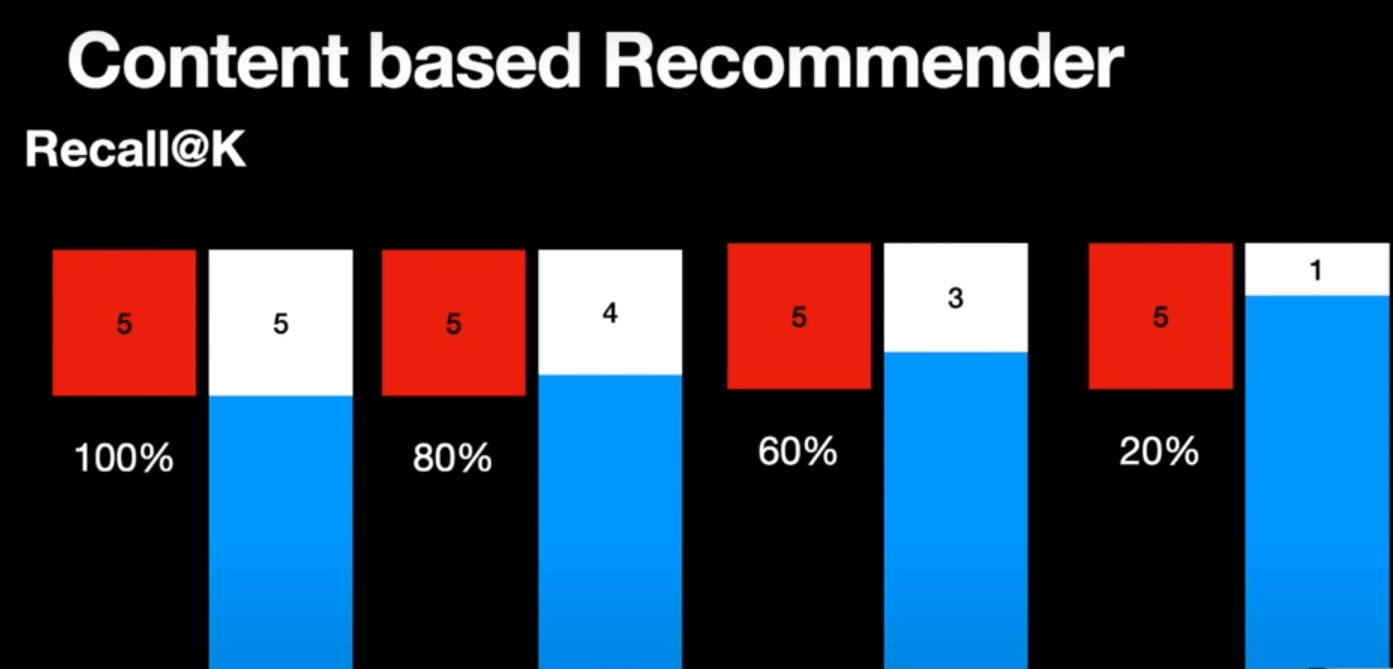

In [53]:
interactions_full_indexed = interactions_full.set_index('personId')
interactions_train_indexed = interactions_train.set_index('personId')
interactions_test_indexed = interactions_test.set_index('personId')

In [57]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class Model_Eval:
    def get_items_interacted(personId, interactions_df):
        #get user data
        interacted_items = interactions_df.loc[personId]['contentId']
        return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

    def get_not_interacted(self, personId, sample_size, seed = 42):
        interacted_items = get_items_interacted(personId, interactions_full_indexed)
        all_items = set(cleaned_article['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)

        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        
        return set(non_interacted_items_sample)

    def verify_hit_top(self, item_id, recommended_items, topn):
        try:
            index = next(i for i,c in enumerate(recommended_items) if c== item_id)
        except:
            index-=1

        hit = int(index in range(0, topn))

        return hit,index

    def evaluate_model_for_user(self, model, personId):
        #Getting items in test set
        interacted_testset = interactions_test_indexed.loc[personId]
        if type(interacted_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_testset['contentId'])])

        interacted_items_count_testset = len(person_interacted_items_testset)
        #Getting ranked recommmendation list
        person_recs_df  = model.recommend(personId, 
                                          items_to_ignore = get_items_interacted(personId, interactions_train_indexed),
                                          topn=10000000000)
        hits_5 = 0
        hits_10 = 0

        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted (to represent items that are assumed to be not relevant to the user)
            non_interacted_sample = self.get_not_interacted(personId, sample_size = EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                                                            seed = item_id%(2**32))
            #Combining interacted with the sample
            items_to_filter_recs = non_interacted_sample.union(set([item_id]))
            #Filtering
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if current interacted is in top N recommended
            hit_at_5, index_at_5 = self.verify_hit_top(item_id, valid_recs, 5)
            hits_5 += hit_at_5
            hit_at_10, index_at_10 = self.verify_hit_top(item_id, valid_recs, 10)
            hits_10 += hit_at_10
            
        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5/ float(interacted_items_count_testset)
        recall_at_10 = hits_at_10/ float(interacted_items_count_testset)

        person_metrics = {"hits@5": hits_5,
                         "hits@10": hits_10,
                         "interacted_count": interacted_items_count_testset,
                         "recall@5": recall_at_5,
                         "recall@10": recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        people_metrics = []
        for idx, personId in enumerate(list(interactions_test_indexed.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, personId)
            person_metrics['_person_id'] = personId

            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending = False)
        global_recall_at_5 = detailed_df['hits@5'].sum() / float(detailed_df['interacted_count'].sum())
        global_recall_at_10 = detailed_df['hits@10'].sum() / float(detailed_df['interacted_count'].sum())

        global_metrics = {"modelName": model.get_model_name(),
                         "recall@5": global_recall_at_5,
                         "recall@10": global_recall_at_10}
        
        return global_metrics, detailed_df

In [58]:
def get_items_interacted(personId, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[personId]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [59]:
model_eval = Model_Eval()
print('Evaluating Content-Based Filtering model...')

cb_global_metrics, cb_detailed_results_df = model_eval.evaluate_model(content_based_recommender_model)

print('\nGlobal metrics:\n%s' % cb_global_metrics)

cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...


<ipython-input-57-9f170e3f9959>:17: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)


UnboundLocalError: local variable 'index' referenced before assignment

# Store model artifact

In [60]:
#import pickle
#pickle.dump( item_ids, open( "../service/item_ids.p", "wb" ) )
#pickle.dump( user_profiles, open( "../service/user_profiles.p", "wb" ) )
#pickle.dump( tfidf_matrix, open( "../service/tfidf_matrix.p", "wb" ) )
#pickle.dump( content_based_recommender_model, open( "../service/content_based_recommender_model.p", "wb" ) )